# Noise Propagation in CSE-MRI

    Author: Diego Hernando, PhD, University of Wisconsin-Madison
    Date created: November 25, 2021
    Date last modified: December 8, 2021
    
## Fat quantification signal model (magnitude signal shown): 


<font size="4">

<br>

$s(TE) = \left| \left( A_{\hbox{water}} + A_{\hbox{fat}} \sum_{p=1}^P \rho_p e^{i 2 \pi TE f_p} \right) e^{-  TE \, R_2^* } \right|$

**Known parameters**: TE values (say, 6 echo times), $\rho_p$ and $f_p$ (fat NMR peak relative amplitudes and frequencies)


**Unknown parameters**: $A_{\hbox{water}}$, $A_{\hbox{fat}}, R_2^*$

**Fat quantification**: FF = $ A_{\hbox{fat}} / (A_{\hbox{fat}} + A_{\hbox{water}})$
    
**Note**: The signal fitting code below measures FF directly with the formulation:
    
$s(TE) =  \left| A \left( (1-FF) + FF\sum_{p=1}^P \rho_p e^{i 2 \pi TE f_p} \right) e^{-  TE \, R_2^* } \right|$    

where $A$ is the overall signal amplitude

</font>


In [3]:
## Load some python packages
##
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend import Legend
from matplotlib import lines
from IPython.display import display, Image
from dataclasses import dataclass
from scipy.optimize import curve_fit
import scipy.special as special
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [11]:
# Declare a couple helpful classes and functions

@dataclass
class trueParams: # Tissue parameters to simulate chemical shift encoded signal
    A: float
    ff: float
    r2star: float
    fieldmap: float = 0.0
        
@dataclass
class imDataParams: # Acquisition parameters to simulate chemical shift encoded signal
    FieldStrength: float
    TE: list
        

@dataclass
class algoParams: # Specifies signal model for chemical shift encoded signal
    fatFreqs: list
    fatAmps: list
    USE_R2: bool    
        

# This function synthetizes some CSE signal given tissue, acquisition, and signal model        
def create_signal(imP, trueP, algoP):
    sw = trueP.A*(1-trueP.ff*0.01)*np.ones(len(imP.TE))
    sf = 0*imP.TE
    
    for n in range(0, len(algoP.fatFreqs)):
        sf = sf + algoP.fatAmps[n]*trueP.A*trueP.ff*0.01*np.exp(1j*2*np.pi*imP.TE*algoP.fatFreqs[n]*imP.FieldStrength*42.576)
        #sf = sf + imP.TE
    s = sw + sf
    
    if algoP.USE_R2:
        s = s*np.exp(-imP.TE*trueP.r2star + 1j*2*np.pi*imP.TE*trueP.fieldmap)
    else:
        s = s*np.exp(1j*2*np.pi*imP.TE*trueP.fieldmap)
    
    return s

# Wrapper for create_signal function above     
def create_signal_r2star(TE, A, ff, r2star):
    
    global myImDataParams
    global myAlgoParams
    
    fieldmap = 0
    myTrueParams = trueParams(A, ff, r2star,fieldmap)

    s = create_signal(myImDataParams, myTrueParams, myAlgoParams)
    
    s2 = np.abs(s)
       
    return s2


# Wrapper for create_signal function above, without including R2* in the model     
def create_signal_nor2star(TE, A, ff):
    
    global myImDataParams
    global myAlgoParams
    
    r2star = 0
    fieldmap = 0
    myTrueParams = trueParams(A, ff, r2star,fieldmap)

    s = create_signal(myImDataParams, myTrueParams, myAlgoParams)
    
    s2 = np.abs(s)
    
    return s2


# Make the fonts large
font = {'weight' : 'normal',
        'size'   : 26}

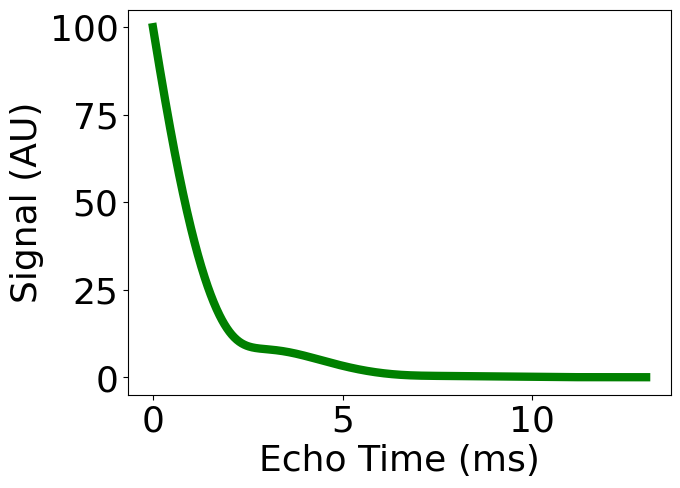

In [15]:
# Generate some reasonable parameters and signal
field_strength = 1.5 # Field strength in Tesla

global myAlgoParams 
global myImDataParams
global t
global s1

# Set some parameters for plotting a continuous-looking CSE signal
N = 1001
tmax = 13*0.001
t = np.linspace(0.0,tmax,N)

# Set some true FF and R2* (can try different values but for this 
# exercise we will end up fixing them at 30.0 and 100.0, respectively)
true_FF = 30.0
true_R2star = 667

myTrueParams = trueParams(100., true_FF, true_R2star, 0.)

fFreq = [-3.80, -3.40, -2.60, -1.94, -0.39, 0.60];
fAmps = [0.087, 0.693, 0.128, 0.004, 0.039, 0.048];
myAlgoParams = algoParams(fFreq, fAmps, True )

myImDataParams = imDataParams(field_strength, t) # Field strength is given here
s1 = create_signal(myImDataParams, myTrueParams , myAlgoParams);

plt.figure(figsize=(7,5))
plt.plot(t*1000,abs(s1),'green',linewidth=6.0);
plt.xlabel('Echo Time (ms)');
plt.ylabel('Signal (AU)');
plt.rc('font', **font)


In [4]:
import scipy.stats as stats

# Plot the least-squares signal fit given some echo time combination
def showFitNoise(FF, R2star, TE1,dTE, SNR, Npixels):
    global myAlgoParams 
    global myImDataParams
    global t
    global s1
    
    font = {'weight' : 'normal',
        'size'   : 16}
    
    A = 100.
    myTrueParams = trueParams(A, FF, R2star, 0.)

    
    # Generate continuous-looking noiseless true signal
    N = 1001
    tmax = 20*0.001
    t = np.linspace(0.0,tmax,N)
    myImDataParams = imDataParams(1.5, t)
    s1 = create_signal(myImDataParams, myTrueParams, myAlgoParams );

    
    TE1 = TE1*0.001
    dTE = dTE*0.001
    nTE = 6
    TE = np.linspace(TE1,TE1 + (nTE-1)*dTE,nTE)
    myImDataParams = imDataParams(1.5, TE)   
    s = create_signal(myImDataParams, myTrueParams , myAlgoParams);

    
    sigma = A/SNR;
    #Npixels = 1;
    
    ffest = np.zeros(Npixels)

    r2est = np.zeros(Npixels)
    
    sfit3 = np.zeros((N, Npixels))
    snall = np.zeros((nTE, Npixels))
    for k in range(Npixels):
        sn = s +  stats.norm.rvs(0, sigma, size=(nTE)) + stats.norm.rvs(0, sigma, size=(nTE))*1j
        snall[:,k] = np.abs(sn) 

        p0 = np.array([90.,40.,50.])
        
        try:
            popt, pcov = curve_fit(create_signal_r2star, TE, abs(sn), p0);
        except RuntimeError:
            popt = p0


        sfit2 = create_signal_r2star( TE, popt[0], popt[1], popt[2])
        
        myEstParams = trueParams(popt[0], popt[1], popt[2], 0.)
        mySimParams = imDataParams(1.5, t)
        sfit3[:,k] = np.abs(create_signal(mySimParams, myEstParams , myAlgoParams));
        ffest[k] = popt[1]
        r2est[k] = popt[2]
        
    
    # Display results
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(15, 7)
    fig.subplots_adjust(hspace=0.3,wspace=0.3)
    p2 = axs[0].plot(t*1000,abs(s1),'gray',linewidth=6.0, label="Noiseless signal (continuous)");
    p1 = axs[0].plot(t*1000,abs(sfit3),'#DD010120',linewidth=2.0, label="Fitted signal (continuous)");
    p3 = axs[0].plot(TE*1000,abs(snall),'or',markersize=6, label="Noisy signal (sampled)");
    p4 = axs[0].plot(TE*1000,abs(s),'oc',markersize=12,label="Noiseless signal (sampled)");

    axs[0].set_xlabel('Echo Time (ms)');
    axs[0].set_ylabel('Signal (AU)');
    axs[0].set_title('Magnitude fitting: \nMeasured and estimated signals' );

    axs[0].legend([
           lines.Line2D([0], [0], linewidth=6.0, ls='-', c='gray'),
        lines.Line2D([0], [0],marker='o',markersize=12,  c='c',ls=''),
        lines.Line2D([0], [0], marker='o',markersize=6,  c='r',ls=''),      
        lines.Line2D([0], [0],  linewidth=1.0,ls='-', c='#DD010160')],
          ['Noiseless signal (continuous)',
           'Noiseless signal (sampled)',
           'Noisy signal (sampled)', 
           'Fitted signal (continuous)'])
    
    axs[1].boxplot([r2est,ffest]);
    axs[1].set_ylim([-10, 100])
    axs[1].set_ylabel('R2* and FF estimates');
    axs[1].set_title('True R2* = ' + '{:.1f}'.format(R2star) + ', Estimated R2* =' + '{:.1f}'.format(np.mean(r2est)) + '$\pm$' + '{:.1f}'.format(np.sqrt(np.var(r2est))) + ',\n True FF ='  + '{:.1f}'.format(FF) + ', Estimated FF =' + '{:.1f}'.format(np.mean(ffest)) + '$\pm$' + '{:.1f}'.format(np.sqrt(np.var(ffest)))  );
    axs[1].set_xticklabels(['R2*', 'FF'])
    plt.show()
    plt.rc('font', **font)


In [5]:
## Interactive plot to demonstrate noise propagation in 
## magnitude based CSE-MRI estimates of R2* and PDFF
y = interactive(showFitNoise,FF=(0,50,1),
                R2star=(20,100,10),
                TE1=(0.4,4.0,0.01),
                dTE=(0.6,4.0,0.01), 
                SNR=(2,50,1), 
                Npixels=fixed(100))
display(y)

interactive(children=(IntSlider(value=25, description='FF', max=50), IntSlider(value=60, description='R2star',…

## Effective number of signal averages (NSA)

How can we quantify the noise propagation from our acquired echo images to our resulting output images obtained from CSE-based fitting? One reasonable approach is to compare the noise variance ($\sigma^2$) at the input (in the echo images) vs the noise variance at the output (say, in the fat-only image). This has the advantage that we can compare to a simple averaging process, where the variance will decrease proportionally to the number of averages $N$ ($\sigma_{ave}^2 = \sigma^2/N$). This way, if we know how the variance in the fat-only image ($\sigma^2_{fat}$) relates to the variance in the echo images ($\sigma^2$), we can calculate the effective number of signal averages (NSA) that we are obtaining in the water-fat separation process (i.e., what is the equivalent noise performance that we would obtain through simple averaging). 

$$NSA = \frac{\sigma^2}{\sigma^2_{fat}}$$

where the value of NSA will be between $0$ (in a terrible case where we are not able to obtain any reasonable fat images) and $N_{echoes}$ (in an ideal case where we optimally use our echoes to generate high-SNR water-fat separated images). As we show below, NSA is highly dependent on the choice of echo times, and also depends heavily on how we fit our signals (magnitude vs complex fitting, with the latter giving higher NSA). Note that $NSA = N_{echoes}$ is achievable if we do not include $R_2^*$ in the model (as in the original IDEAL echo times), but generally not achievable in the presence of $R_2^*$ decay. 

In the following cells, we calculate NSA for both magnitude and complex fitting, for a range of echo time combinations indexed by the initial echo time $TE_1$ and the echo spacing $\Delta TE$. 

In each case, we calculate a theoretical NSA using the Cramer-Rao Lower Bound (CRLB). The CRLB provides a measure (actually a bound) of the noise propagation achievable in the presence of a given signal model, sampling parameters, and noise distribution. Note that we could also estimate noise propagation in each case using simulations, as in the cells above. However, this would be computationally expensive and potentially algorithm-dependent. In contrast, the CRLB is a good tool to rapidly predict NSA in an algorithm-independent manner.

We will not go over the details of the CRLB in this description, but a few good references include:

    Scharf and MacWhorter, Geometry of the Cramer-Rao bound, 1992

    Pineda, Reeder, Wen, and Pelc, Cramér-Rao bounds for three-point decomposition of water and fat, 2005

    Hernando, Liang, and Kellman, Chemical shift–based water/fat separation: A comparison of signal models, 2010

## Water-fat separation signal model (complex signal): 


<font size="4">

<br>

$s(TE) = \left( A_{\hbox{water}} + A_{\hbox{fat}} \sum_{p=1}^P \rho_p e^{i 2 \pi TE f_p} \right) e^{-  TE \, R_2^* } e^{i 2 \pi f_B TE + i \phi } $

**Known parameters**: TE values (say, 6 echo times), $\rho_p$ and $f_p$ (fat NMR peak relative amplitudes and frequencies)


**Unknown parameters**: $A_{\hbox{water}}$, $A_{\hbox{fat}}, R_2^*, f_B, \phi$

**Fat quantification**: FF = $100 \cdot A_{\hbox{fat}} / (A_{\hbox{fat}} + A_{\hbox{water}})$

</font>

In [96]:
def CRLB_CSE_complex(fm,a,fF,relAmps,r2,phi,t,sigma):
    N = np.size(t)
    
    FS, T = np.meshgrid(fF,t)
    RA, T = np.meshgrid(relAmps,t)
    
    D = np.zeros((N,5)) + 1j*np.zeros((N,5)) 
        
    # Derivative wrt a[0]
    D[:,0] = np.exp(1j*(phi + 2*np.pi*fm*t) - r2*t)
    
    # Derivative wrt a[1]
    D[:,1] = np.sum(RA*np.exp(1j*2*np.pi*fm*T)*np.exp(1j*phi+ 1j*2*np.pi*FS*T),1)
    
    # Derivative wrt r2
    D[:,2] = -t*np.exp(1j*(phi + 2*np.pi*fm*t) - r2*t)*(a[0] + a[1]*np.sum(RA*np.exp(1j*2*np.pi*FS*T),1))
    
    # Derivative wrt phi
    D[:,3] = 1j*np.exp(1j*(phi + 2*np.pi*fm*t) - r2*t)*(a[0] + a[1]*np.sum(RA*np.exp(1j*2*np.pi*FS*T),1))

    # Derivative wrt fm
    D[:,4] = 1j*2*np.pi*t*np.exp(1j*(phi + 2*np.pi*fm*t) - r2*t)*(a[0] + a[1]*np.sum(RA*np.exp(1j*2*np.pi*FS*T),1))

    D = np.matrix(D)
    
    C = np.linalg.inv(np.real(np.matmul(D.H,D)))*(sigma**2)

    return C 


## Water-fat separation signal model (magnitude signal): 


<font size="4">

<br>

$s(TE) = \left| \left( A_{\hbox{water}} + A_{\hbox{fat}} \sum_{p=1}^P \rho_p e^{i 2 \pi TE f_p} \right) e^{-  TE \, R_2^* } \right|$

**Known parameters**: TE values (say, 6 echo times), $\rho_p$ and $f_p$ (fat NMR peak relative amplitudes and frequencies)


**Unknown parameters**: $A_{\hbox{water}}$, $A_{\hbox{fat}}, R_2^*$

**Fat quantification**: FF = $100 \cdot A_{\hbox{fat}} / (A_{\hbox{fat}} + A_{\hbox{water}})$

</font>

In [97]:
def CRLB_CSE_magn(a,fF,relAmps,r2,t,sigma):
    N = np.size(t)
    
    FS, T = np.meshgrid(fF,t)
    RA, T = np.meshgrid(relAmps,t)
    
    D = np.zeros((N,5)) + 1j*np.zeros((N,5)) 

    # Signal magnitude
    shat = np.abs(a[0]*np.exp(-r2*t) + a[1]*np.sum(RA*np.exp(1j*2*np.pi*FS*T)*np.exp(-r2*T),1))

    # Matrix A: partial derivatives
    k1 = np.real(np.sum(RA*np.exp(1j*2*np.pi*FS*T),1))
    k2 = np.imag(np.sum(RA*np.exp(1j*2*np.pi*FS*T),1))
    J = np.zeros((4,N))
    ds1 = (a[0]*np.exp(-2*r2*t) + a[1]*k1*np.exp(-2*r2*t))/shat
    ds2 = (a[0]*k1*np.exp(-2*r2*t) + a[1]*(k1**2 + k2**2)*np.exp(-2*r2*t))/shat
    ds3 = -t*shat
    A = np.matrix([ds1, ds2, ds3]).T
    
    # Matrix V: diagonal with noise variances
    V = sigma**2*np.eye(N);
    
    # Matrix ER: The rician "touch"
    rdiag = np.zeros((N))
    for kn in range(N):
        trueamp = shat[kn]
        ms = np.linspace(0,1.5*trueamp+8*sigma,1000)
        dm = ms[1] - ms[0]
        zs = ms*trueamp/(sigma**2)
        
        if trueamp/sigma < 8:
            pric = ms/(sigma**2)*np.exp(-((ms**2 + trueamp**2)/(2*sigma**2)))*np.i0(zs);
            rdiag[kn] = -trueamp**2/sigma**2 + 1/(sigma**2)*np.sum(dm*pric*(ms**2)*special.iv(1,zs)**2/np.i0(zs)**2);
        else:
            mu2 = np.sqrt(trueamp**2+sigma**2);
            pric = (2*np.pi*sigma**2)**(-0.5) * np.exp(-0.5*(ms-mu2)**2/sigma**2);
            rdiag[kn] = 1;
    ER = np.diag(rdiag); 
    

    
    # Finally, invert Fisher matrix to get CRLB
    F = np.matmul(A.H, np.matmul( np.linalg.inv(V), np.matmul(ER,A)));
    C = np.linalg.inv(F);
    return C        
    

In [98]:
# Plot the NSA for fat estimation across various echo time combinations
# for some choice of FF, R2*,  Number of Echoes, and SNR
def showFatNSA(FF, R2star, Nechoes, SNR):

    fm = 0.
    a = [100-FF,FF]
    fF = np.zeros((1,6))
    fF[:] = [-3.80, -3.40, -2.60, -1.94, -0.39, 0.60];
    fF = fF*42.576*1.5
    relAmps = [0.087, 0.693, 0.128, 0.004, 0.039, 0.048];
    r2 = R2star
    phi = 0.
    sigma = 100/SNR

    nTE1 = 41;
    ndTE = 25;
    TE1s = np.linspace(0,2.5,nTE1)
    dTEs = np.linspace(0.8,2.8,ndTE)
    nTE = Nechoes


    f_nsa_magn = np.zeros((nTE1,ndTE))
    f_nsa_complex = np.zeros((nTE1,ndTE))

    for k1 in range(np.size(TE1s)):
        for k2 in range(np.size(dTEs)):
            TE1 = TE1s[k1]*0.001
            dTE = dTEs[k2]*0.001
            TE = np.linspace(TE1,TE1 + (nTE-1)*dTE,nTE)

            C = CRLB_CSE_magn(a,fF,relAmps,r2,TE,sigma);
            f_nsa_magn[k1,k2] = sigma**2/C[1,1]

            C2 = CRLB_CSE_complex(fm, a, fF, relAmps, r2, phi, TE, sigma)
            f_nsa_complex[k1,k2] = sigma**2/C2[1,1]


    # Display the bias and the standard deviation in R2* estimates 
    # as a function of TE combination             
    plt.figure(figsize=(15,7))
    plt.subplot(1,2,1)
    plt.imshow(f_nsa_magn,interpolation='bicubic', extent = [dTEs[0], dTEs[-1], TE1s[-1], TE1s[0] ], vmin=0, vmax=nTE/3*2);
    plt.xlabel('$\Delta$TE (ms)');
    plt.ylabel('TE$_1$ (ms)');
    plt.title('Fat NSA (magnitude fitting)' );
    plt.jet()
    plt.colorbar()
    plt.rc('font', **font)
    plt.subplot(1,2,2)
    plt.imshow(f_nsa_complex,interpolation='bicubic',extent = [dTEs[0], dTEs[-1], TE1s[-1], TE1s[0] ], vmin=0, vmax=nTE/3*2);
    plt.xlabel('$\Delta$TE (ms)');
    plt.ylabel('TE$_1$ (ms)');
    plt.title('Fat NSA (complex fitting)' );
    plt.jet()
    plt.colorbar()
    plt.rc('font', **font)


In [99]:
## Create interactive slide bar to calculate NSA for magnitude and complex fitting
y = interactive(showFatNSA,
                FF=(0,50,1),
                R2star=(0,100,10),
                Nechoes=(3,12,1), 
                SNR = fixed(20))
display(y)

interactive(children=(IntSlider(value=25, description='FF', max=50), IntSlider(value=50, description='R2star',…